# 16018942 Assignment 2

### Table of Contents
1. [Question 1](#question1)
2. [Question 2](#question2)

###### N.B Notebook runs in $\approx 40s$ on computer used for development (Ubuntu 18.04.3 LTS, Intel® Core™ i7-6600U CPU @ 2.60GHz × 4) and formatting has been checked with autopep8 (https://pypi.org/project/autopep8/)


In [1]:
# Importing libraries.
import pyopencl as cl
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import aslinearoperator
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
from scipy.sparse import csgraph

# Magic command to keep plots in the notebook.
%matplotlib inline

In [2]:
# Making pyopencl output verbose.
import os
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'


In [3]:
# Importing library and setting up class for timing performance.
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## Question 1
<a id="question1"></a>

Need to create a fast OpenCL way to perform matrix multipication with a matrix in CSR format.

### Using scipy and python (no OpenCL yet to answer question)
This was just a primer for understanding using the CSR format and provided matrices to test the subsequent classes.

In [4]:
# Making matrices for testing purposes.
n = 2**11
dtype='float32'
omega = sp.sparse.csr_matrix(
    np.random.randint(0,10,(n, n)).astype(dtype))
charlie = np.random.randint(0,10,(n, 1)).astype(dtype)
delta = np.random.randint(0,10,(n)).astype(dtype)

In [5]:
def csr_multiplication(A,B):
    '''Function to perform matrix multiplication
    with scipy linearoperator constructor.'''
    #Operator = left_multiplied_operator(A,np.size(A))
    
    C = aslinearoperator(A).matvec(B)
    
    return C

In [6]:
# Verifying that both methods are correct.
print(
    'Are matrix multiplication results for numpy and scipy method equal ?:'
      ,np.array_equal(np.dot(omega.toarray(),charlie)
                      ,csr_multiplication(omega,charlie))
     )

Are matrix multiplication results for numpy and scipy method equal ?: True


### Question 1 with Betcke CSR method in OpenCL with no SIMD

Start by writing the CSR matrix multiplication algorithm given to us by Betcke in lectures in plain python.

In [7]:
def mat_vec(x,data,indices,indptr):
    '''Python only function to perform matrix multiplication
    with a mtrix in CSR format as input'''
    y = np.zeros((x.shape[0],1),dtype="float64")
    n = len(indptr)-1
    for i in range(n):
        y[i] = data[indptr[i]:indptr[i+1]].dot(
        x[indices[indptr[i]:indptr[i+1]]])
    return y

In [8]:
def mat_vec_OpenCL(x,data,indices,indptr):
    '''Function written with openCL to compute
    the matrix multiplication of a mtrix in CSR
    format and a vector in normal array format.
    Outputs array.'''
    
    # Setup array for results.
    y = np.zeros((x.shape[0],1),dtype="float32")
    
    # Get size of array from input.
    n = len(indptr)-1
    
    # Setup openCL and create on device storage.
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    x_device = cl.Buffer(
        ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x)
    data_device = cl.Buffer(
        ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=data)
    indices_device = cl.Buffer(
        ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=indices)
    indptr_device = cl.Buffer(
        ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=indptr)
    y_device = cl.Buffer(
        ctx, mf.WRITE_ONLY, y.nbytes)
    
    # Creating OpenCL kernel that performs the marix multiplication.
    kernel = """
    __kernel void mat_vec(const int N,
                          const __global float* x,
                          const __global float* data,
                          const __global int* indices,
                          const __global int* indptr,
                          __global float* y) {

            // Thread identifiers
            const int i = get_global_id(0);
            const int j = get_global_id(1);
            
            float element = 0.0f;
            
            for(int j=indptr[i];j<indptr[i+1];j++){
                element += data[j] * x[indices[j]];
            }
            y[i]=element;

    

        }
    """

    # Setup number of workgroups.
    ts = 4
    
    # Build the openCL program.
    prg = cl.Program(ctx, kernel).build()
    mat_vec = prg.mat_vec
    
    # Run the openCL program.
    event = mat_vec(
        queue, (n, n), (ts, ts), np.int32(n),
        x_device, data_device, indices_device,
        indptr_device, y_device)
    event.wait()
    
    # Copy results from openCL program back into Python.
    cl.enqueue_copy(queue, y, y_device)
    event.wait()
    queue.finish()
    
    return y

In [9]:
# Get CSR data of array.
omega_data = omega.data
omega_indices = omega.indices
omega_indptr = omega.indptr

In [10]:
with Timer() as t:
    csr_multiplication(omega,charlie)
print("Time to run with scipy: {0}".format(t.interval))

with Timer() as t:
    np.dot(omega.toarray(),charlie)
print("Time to run with numpy: {0}".format(t.interval))

with Timer() as t:
    mat_vec_OpenCL(charlie,omega_data,omega_indices,omega_indptr)
print("Time to run with openCL: {0}".format(t.interval))

Time to run with scipy: 0.0058100223541259766
Time to run with numpy: 0.025942087173461914
Time to run with openCL: 2.880312204360962


In [11]:
# Verifying if openCL function works.
print('Are matrix multiplication results for openCL and scipy method equal ?:'
      ,np.array_equal(
          mat_vec_OpenCL(
              charlie,omega_data,omega_indices,omega_indptr),
                      csr_multiplication(omega,charlie))
     )

Are matrix multiplication results for openCL and scipy method equal ?: True


Now that it is working we can restructure the code into a class rather than being a series of functions.

In [12]:
class OpenCL_CSR_product:
    '''Class used to represent Matrix vector
    multiplication with CSR formatted matrices.'''
    
    
    def __init__(self,data,indices,indptr):
        '''Constructor function to create the openCL program
        for computing the matrix-vector product.'''
        
        
        # Get size of array from input.
        self.n = len(indptr)-1
        
        # Setup array for results.
        self.y = np.zeros((self.n,1),dtype="float32")


        # Setup openCL and create on device storage.
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags

        self.data_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=data)
        self.indices_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=indices)
        self.indptr_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=indptr)
        self.y_device = cl.Buffer(
            self.ctx, self.mf.WRITE_ONLY, self.y.nbytes)

        # Creating OpenCL kernel that performs the marix multiplication.
        self.kernel = """
        __kernel void mat_vec(const int N,
                              const __global float* x,
                              const __global float* data,
                              const __global int* indices,
                              const __global int* indptr,
                              __global float* y) {

                // Thread identifiers
                const int i = get_global_id(0);
                const int j = get_global_id(1);

                float element = 0.0f;

                for(int j=indptr[i];j<indptr[i+1];j++){
                    element += data[j] * x[indices[j]];
                }
                y[i]=element;



            }
        """

        # Setup number of workgroups.
        self.ts = 4

        # Build the openCL program.
        self.prg = cl.Program(self.ctx, self.kernel).build()
        
    def multiplication(self,v):
        '''Function to run the multiplication of the matrix
        with a given input vector.'''
        
        self.x_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=v)
        
        # Run the openCL program.
        self.event = self.prg.mat_vec(self.queue, (self.n, self.n), (self.ts, self.ts),
                        np.int32(self.n), self.x_device, self.data_device,
                        self.indices_device, self.indptr_device, self.y_device)
        self.event.wait()

        # Copy results from openCL program back into Python.
        cl.enqueue_copy(self.queue, self.y, self.y_device)
        self.event.wait()
        self.queue.finish()
        
        return self.y
        

In [13]:
OpenCLProd = OpenCL_CSR_product(omega_data,omega_indices,omega_indptr) 

In [14]:
print(OpenCLProd.multiplication(charlie))

[[42478.]
 [41970.]
 [41516.]
 ...
 [41045.]
 [41524.]
 [42261.]]


In Question 1 in the assignment PDF it indicates that the class should derive from the LinearOperator type. An extra function is added to this class to make the class object of type LinearOperator.

In [15]:
class ScipyLinOpOpenCL:
    '''Class used to represent Matrix vector
    multiplication with CSR formatted matrices.'''
    
    
    def __init__(self,data,indices,indptr):
        '''Constructor function to create the openCL program
        for computing the matrix-vector product.'''
        
        
        # Get size of array from input.
        self.n = len(indptr)-1
        
        # Setup array for results.
        self.y = np.zeros((self.n,1),dtype="float32")


        # Setup openCL and create on device storage.
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags

        self.data_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=data)
        self.indices_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=indices)
        self.indptr_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=indptr)
        self.y_device = cl.Buffer(
            self.ctx, self.mf.WRITE_ONLY, self.y.nbytes)

        # Creating OpenCL kernel that performs the marix multiplication.
        self.kernel = """
        __kernel void mat_vec(const int N,
                              const __global float* x,
                              const __global float* data,
                              const __global int* indices,
                              const __global int* indptr,
                              __global float* y) {

                // Thread identifiers
                const int i = get_global_id(0);
                const int j = get_global_id(1);

                float element = 0.0f;

                for(int j=indptr[i];j<indptr[i+1];j++){
                    element += data[j] * x[indices[j]];
                }
                y[i]=element;



            }
        """

        # Setup number of workgroups.
        self.ts = 4

        # Build the openCL program.
        self.prg = cl.Program(self.ctx, self.kernel).build()
        
    def multiplication(self,v):
        '''Function to run the multiplication of the matrix
        with a given input vector.'''
        
        self.x_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=v)
        
        # Run the openCL program.
        self.event = self.prg.mat_vec(self.queue, (self.n, self.n), (self.ts, self.ts),
                        np.int32(self.n), self.x_device, self.data_device,
                        self.indices_device, self.indptr_device, self.y_device)
        self.event.wait()

        # Copy results from openCL program back into Python.
        cl.enqueue_copy(self.queue, self.y, self.y_device)
        self.event.wait()
        self.queue.finish()
        
        return self.y
    
    def create(self):
        return LinearOperator((self.n,self.n),matvec=self.multiplication)

In [16]:
Op23 = ScipyLinOpOpenCL(
    omega_data,omega_indices,omega_indptr).create()
print(Op23.matvec(charlie))

[[42478.]
 [41970.]
 [41516.]
 ...
 [41045.]
 [41524.]
 [42261.]]


The last optimisation we can do is to sensure that OpenCL is using SIMD provided by AVX2.
From reading (https://www.fz-juelich.de/SharedDocs/Downloads/IAS/JSC/EN/slides/opencl/opencl-04-vector.pdf?__blob=publicationFile) I learnt that OpenCL compiler is smart enough to auto vectorise a task if it is written in the correct manner, thus negating the need to explicitly write out the vectorisation of the task. By adding '__attribute__((vec_type_hint(float4)))' in the kernal declaration it ensures that the compiler understands how to auto vectorise the kernel.

In [17]:
class ScipyLinOpOpenCLSIMD:
    '''Class used to represent Matrix vector
    multiplication with CSR formatted matrices.'''
    
    
    def __init__(self,data,indices,indptr):
        '''Constructor function to create the openCL program
        for computing the matrix-vector product.'''
        
        
        # Get size of array from input.
        self.n = len(indptr)-1
        
        # Setup array for results.
        self.y = np.zeros((self.n,1),dtype="float32")


        # Setup openCL and create on device storage.
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags

        self.data_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=data)
        self.indices_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=indices)
        self.indptr_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=indptr)
        self.y_device = cl.Buffer(
            self.ctx, self.mf.WRITE_ONLY, self.y.nbytes)

        # Creating OpenCL kernel that performs the marix multiplication.
        self.kernel = """
        __kernel void __attribute__((vec_type_hint(float4))) mat_vec(const int N,
                              const __global float* x,
                              const __global float* data,
                              const __global int* indices,
                              const __global int* indptr,
                              __global float* y) {

                // Thread identifiers
                const int i = get_global_id(0);
                const int j = get_global_id(1);

                float element = 0.0f;

                for(int j=indptr[i];j<indptr[i+1];j++){
                    element += data[j] * x[indices[j]];
                }
                y[i]=element;



            }
        """

        # Setup number of workgroups.
        self.ts = 4

        # Build the openCL program.
        self.prg = cl.Program(self.ctx, self.kernel).build()
        
    def multiplication(self,v):
        '''Function to run the multiplication of the matrix
        with a given input vector.'''
        
        self.x_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=v)
        
        # Run the openCL program.
        self.event = self.prg.mat_vec(self.queue, (self.n, self.n), (self.ts, self.ts),
                        np.int32(self.n), self.x_device, self.data_device,
                        self.indices_device, self.indptr_device, self.y_device)
        self.event.wait()

        # Copy results from openCL program back into Python.
        cl.enqueue_copy(self.queue, self.y, self.y_device)
        self.event.wait()
        self.queue.finish()
        
        return self.y
    
    def create(self):
        return LinearOperator((self.n,self.n),matvec=self.multiplication)

In [18]:
with Timer() as t:
    ScipyLinOpOpenCLSIMD(
    omega_data,omega_indices,omega_indptr).multiplication(charlie)
print("Time to run with SIMD: {0}".format(t.interval))

with Timer() as t:
    ScipyLinOpOpenCL(
    omega_data,omega_indices,omega_indptr).multiplication(charlie)
print("Time to run without SIMD: {0}".format(t.interval))

Time to run with SIMD: 3.7374775409698486
Time to run without SIMD: 2.7657182216644287


The decrease in performance that can be seen suggests that the auto vectorisation being done automatically by OpenCL without any adjustment is actually faster for this task, but it can be noted that as the task size gets larger (i.e. the arrays used are bigger) the SIMD enforced version seems to be faster. Below can be seen a kernel (included for thoroughness) that was tried at some stage (which worked correctly), the vectorisation was done explicitly but this was found to be much slower, implying that whatever auto vectorisation that OpenCL is inherently doing is the best for this computation task,

```C

kernel = """
        __kernel void mat_vec(
            const int m,
            const int n,
            __global const float *data,
            __global const int *indices,
            __global const int *indptr,
            __global const float *x,
            __global float *v
        )
        {
            int row_id = get_global_id(0);
            float element = 0.0;
            int j = 0;
            float d1[8] = {0.0};
            float u1[8] = {0.0};
            float8 d8 = (float8)(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0);
            float8 u8 = (float8)(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0);
            float8 v8 = (float8)(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0);
            for (int i = indptr[row_id]; i < indptr[row_id + 1]; i++) {
                d1[j] = data[i];
                u1[j] = x[indices[i]];
                j++;
                if (j == 8) {                
                    d8 = (float8)(d1[0], d1[1], d1[2], d1[3], d1[4], d1[5], d1[6], d1[7]);
                    u8 = (float8)(u1[0], u1[1], u1[2], u1[3], u1[4], u1[5], u1[6], u1[7]);
                    v8 = d8 * u8;                
                    element += v8.s0;
                    element += v8.s1;
                    element += v8.s2;
                    element += v8.s3;
                    element += v8.s4;
                    element += v8.s5;
                    element += v8.s6;
                    element += v8.s7;                
                    j = 0;                    
                    d1[0] = 0;
                    d1[1] = 0;
                    d1[2] = 0;
                    d1[3] = 0;
                    d1[4] = 0;
                    d1[5] = 0;
                    d1[6] = 0;
                    d1[7] = 0;
                    u1[0] = 0;
                    u1[1] = 0;
                    u1[2] = 0;
                    u1[3] = 0;
                    u1[4] = 0;
                    u1[5] = 0;
                    u1[6] = 0;
                    u1[7] = 0;
                }
            }            
            d8 = (float8)(d1[0], d1[1], d1[2], d1[3], d1[4], d1[5], d1[6], d1[7]);
            u8 = (float8)(u1[0], u1[1], u1[2], u1[3], u1[4], u1[5], u1[6], u1[7]);
            v8 = d8 * u8;                
            element += v8.s0;
            element += v8.s1;
            element += v8.s2;
            element += v8.s3;
            element += v8.s4;
            element += v8.s5;
            element += v8.s6;
            element += v8.s7;
            v[row_id] = element;            
        }
        """
```

# Question 2
<a id="question2"></a>

Start by creating class for laplacian stencil. This will represent our mathematical approximation for the laplcian with the five point stencil. It should be able to take an input matrix and then act as a linear operator on that matrix and return an approximation of the matrix.

In [19]:
class Laplacian_OpenCL(LinearOperator): 
    '''This class represents a Laplacian LinearOperator.'''
    def __init__(self,m):
        '''Constructor for creating Laplacian instance.'''
        
        self.m = m
        self.shape = (m * m, m * m)

        # Setup OpenCL.
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags

        # OpenCL kernel for 5 point laplician 
        # stencil approximation.
        self.prg = cl.Program(self.ctx, """
            __kernel void operator(const int N,
                                      const __global float* entry,
                                      __global float* results) {

                // Thread identifiers
                const int i = get_global_id(0);
                const int j = get_global_id(1);
                const int anti_separation = (N+1)*(N+1);
                
                float mid = entry[N*i + j];
                float top = entry[N*(i-1) + j];
                float bottom = entry[N*(i+1) + j];
                float minus = entry[N*i + j-1];
                float plus = entry[N*i + j+1];
                
                if (i == 0){
                    top = 0;
                }
                if (i == (N-1)){
                    bottom = 0;
                }
                if (j == 0){
                    minus = 0;
                }
                if (j == (N-1)){
                    plus = 0;
                }
                
                results[N*i + j] = (
                4*mid - top - bottom - minus - plus)*anti_separation;
            }
            """).build()
        
        
    def _matvec(self,line_data):
        '''This function represents the matrix multiplication for the laplacian.'''

        # Setting up class data type.
        self.dtype = line_data.dtype
        
        N = np.int32(self.m)
        
        # Setting up array for results. 
        results = np.zeros_like(line_data).astype('float32')
        
        # Setting up on device storage.
        grid_device = cl.Buffer(
            self.ctx, self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=line_data)
        results_device = cl.Buffer(
            self.ctx, self.mf.WRITE_ONLY, line_data.nbytes)

        linoperator = self.prg.operator

        ts = 1
        
        # Running OpenCL program for given inputs.
        event = linoperator(
            self.queue, (N, N), (ts, ts), N, grid_device, results_device)
        event.wait()

        cl.enqueue_copy(self.queue, results, results_device)
        event.wait()
        self.queue.finish()

        return results
    
    def create(self):
        '''Function to create instant of object as scipy LinearOperator.'''
            
        return LinearOperator((self.m,self.m),matvec=self._matvec)

We then than write some functions to handle some repeated tasks for different systems.

In [20]:
def b_of_system(M):
    '''Function to create b part of system.'''
    return np.ones((M*M), dtype='float32')

In [21]:
def residual(laplacian,solution,b):
    '''Function to calculate residual of
    solution for sytsem'''
    
    return np.linalg.norm(b-laplacian._matvec(solution))/np.linalg.norm(b)

And then some functions for handling different computatations with the conjugate gradient (CG) solver and then plotting the results for the specific situations.

In [22]:
def plot_laplace(iterations,M):
    '''Function to compute and plot solution u.'''
    
    laplacian = Laplacian_OpenCL(M)
    def cg_call_back(xk):
        '''Function used by CG solver for iterating with.'''
        data = xk.reshape(M, M)
    # CG solver.    
    solution,info = cg(
        laplacian,b_of_system(M),
        maxiter = iterations, callback = cg_call_back)
    
    plt.figure(figsize=(11,11))
    plt.imshow(
        solution.reshape(M,M), cmap='viridis',
        origin ='lower',extent=[0,1,0,1])
    
    plt.colorbar(label='Value of $u$ at position')
    plt.title(
        'Heatmap of solution $u$ on unit square for '
        +str(iterations)+' iterations and for square array size: '+str(M))
    plt.xlabel('$i$ Position')
    plt.ylabel('$j$ Position')
    plt.show()

In [23]:
def plot_multi_laplace(iterations,start,end,step):
    '''Function to compute solutions and residuals
    (with a subsequent plot) for an input amount of square
    array sizes.'''
    
    m_values=[]
    residuals=[]
    for i in np.arange(start,end,step):
        laplacian = Laplacian_OpenCL(i)
        def cg_call_back(xk):
            '''Function used by CG solver for iterating with.'''
            data = xk.reshape(i, i)
        
        # CG solver.
        solution,info = cg(
            laplacian,b_of_system(i),
            maxiter = iterations, callback = cg_call_back)
        m_values.append(i)
        residuals.append(residual(laplacian,solution,b_of_system(i)))
    
    plt.figure()
    plt.plot(m_values,residuals)
    plt.yscale('log')
    plt.title(
        'Plot for '+
        str(iterations)+
        ' iterations, for m = {'+str(start)+','+str(end)+'} ')
    plt.xlabel('M')
    plt.ylabel('Residual')
    
    

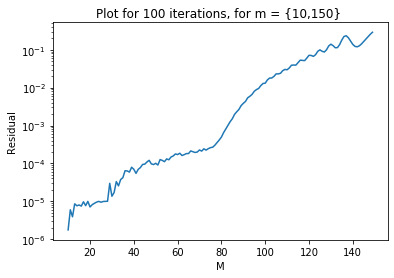

In [24]:
# Plot of the solver for 100 iteratons
# for m = {10,50} with points for every 5 m.
plot_multi_laplace(100,10,150,1)

In [25]:
def plot_multi_laplace_iter(start,end,step):
    '''Function to compute solutions and residuals
    (with a subsequent plot) for varying iterations
    for an input amount of square array sizes.'''
    
    
    plt.figure(figsize=(12,12))
   
    plt.yscale('log')
    plt.title(
        'Convergence plot for different iterations, for m = {'+
        str(start)+','+str(end)+'} ')
    plt.xlabel('M')
    plt.ylabel('Residual')
    
    for k in np.arange(10,110,10):
        m_values=[]
        residuals=[]
        for i in np.arange(start,end,step):
            laplacian = Laplacian_OpenCL(i)
            def cg_callback2(xk):
                '''Function used by CG solver for iterating with.'''
                data = xk.reshape(i, i)
            solution,info = cg(
                laplacian,b_of_system(i),
                maxiter = k, callback = cg_callback2)
            m_values.append(i)
            residuals.append(residual(laplacian,solution,b_of_system(i)))
        lab = 'Iteration number: '+str(k)
        plt.plot(m_values,residuals,label=lab)
        
    
    plt.legend()

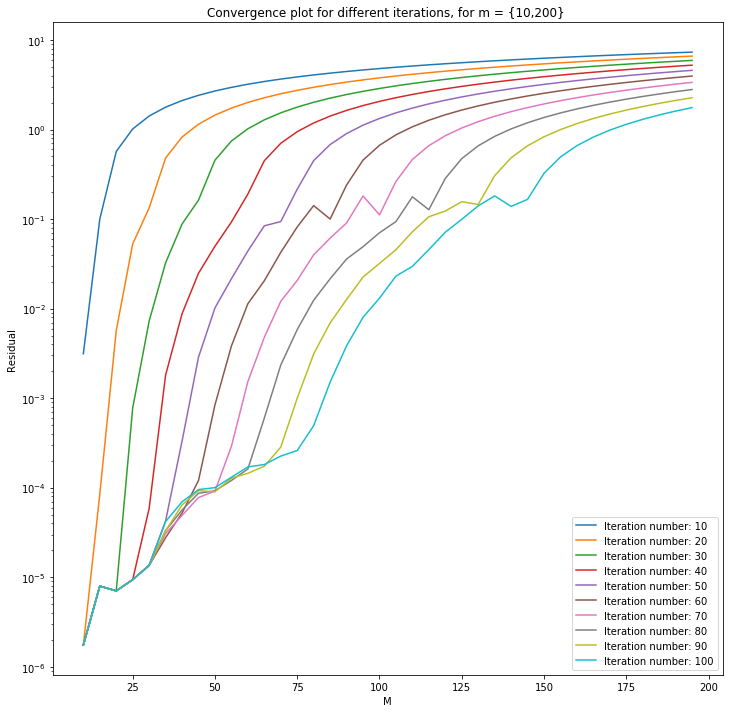

In [26]:
# Plot of the solver for differnt iteratons for m = {10,200} with points for every 5 m.
plot_multi_laplace_iter(10,200,5)

From this plot it would imply that as you increase the size of the array the number of iterations required to reach an acceptable residual increases. Which inherantly is what one would expect.

Finally plotting a best approximate solution on the unit square.

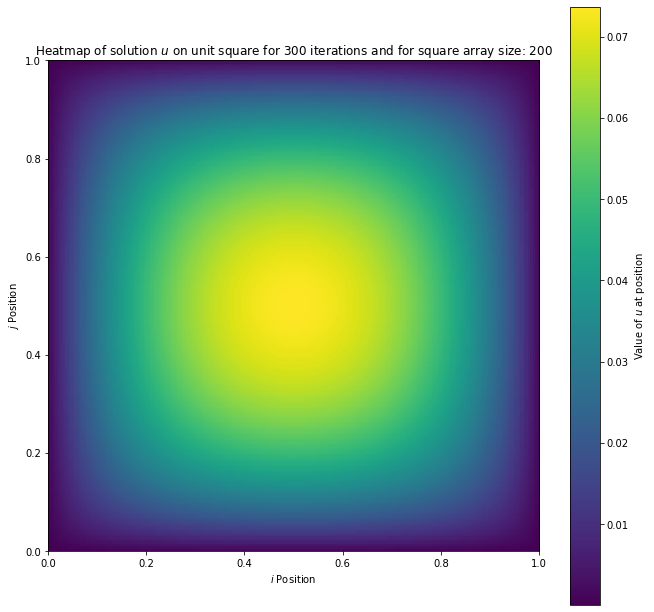

In [27]:
# PLot of solution u on unit square.
plot_laplace(300,200)

The resulting solution appears smooth and continuous, which is what we would expect.